# Disaster Tweet - CSCA 5642 Week 4

This project tackles the Kaggle competition "Natural Language Processing with Disaster Tweets," where the goal is to build a model that can tell the difference between tweets about real disasters and those that just use disaster words as a figure of speech. We'll be building a recurrent neural networks (RNNs) that will analyze the tweet and decide whether it is a real disaster related tweet or not

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from wordcloud import WordCloud

## Data Path

In [171]:
# Path settings

is_kaggle = False

if is_kaggle:
    # kagglt's data are under /kaggle/input
    path_prefix = '/kaggle/input'
else:
    # local path
    path_prefix = '.'

TRAIN_PATH = f'{path_prefix}/nlp-getting-started/train.csv'
TEST_PATH = f'{path_prefix}/nlp-getting-started/test.csv'


In [172]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

## Exploratory Data Analysis

In [173]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [174]:
test_df.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Looks like the "target" column on train data is what represents disaster tweek vs not.  It look like 1 represents disaster tweet and 0 represents non disaster related tweet

In [175]:
print("\nMissing values in training set:")
print(train_df.isnull().sum())
print("Missing values percentage in training set:")
print(train_df.isnull().mean() * 100)

print("\nMissing values in test set:")
print(test_df.isnull().sum())
print("Missing values percentage in test set:")
print(test_df.isnull().mean() * 100)


Missing values in training set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Missing values percentage in training set:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Missing values in test set:
id             0
keyword       26
location    1105
text           0
dtype: int64
Missing values percentage in test set:
id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64


Location is often missing.  We will omit location data from part of the training data.

In [176]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

We have 4342 non disaster tweet vs 3271 disaster tweet in the training dataset

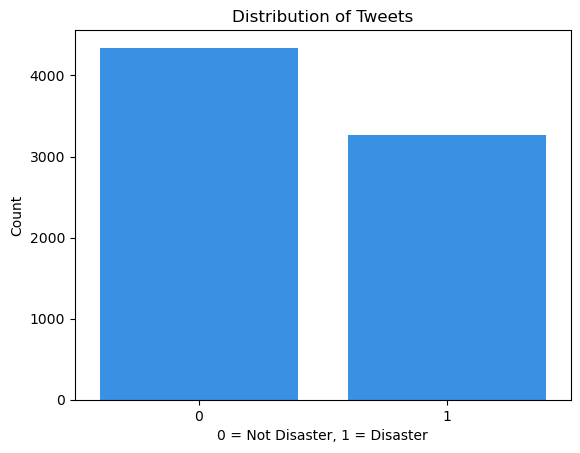

In [177]:
sns.countplot(x='target', data=train_df, color='dodgerblue')
plt.title('Distribution of Tweets')
plt.xlabel('0 = Not Disaster, 1 = Disaster')
plt.ylabel('Count')
plt.show()

In [178]:
train_df['text_length'] = train_df['text'].apply(len)

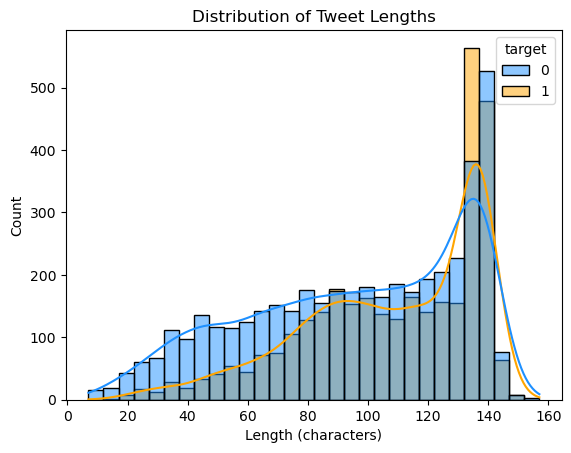

In [179]:
sns.histplot(data=train_df, x='text_length', hue='target', bins=30, kde=True, palette=['dodgerblue', 'orange'])
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length (characters)')
plt.show()

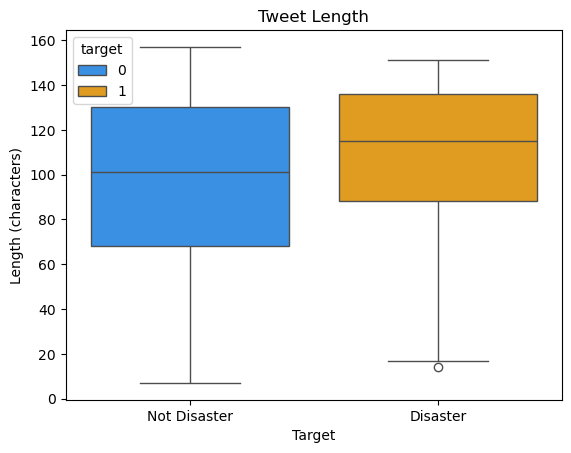

In [180]:
sns.boxplot(x='target', y='text_length', data=train_df, palette=['dodgerblue', 'orange'], hue='target')
plt.title('Tweet Length')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.xlabel('Target')
plt.ylabel('Length (characters)')
plt.show()

In [181]:
train_df['has_hashtag'] = train_df['text'].str.contains('#').astype(int)
train_df['has_mention'] = train_df['text'].str.contains('@').astype(int)

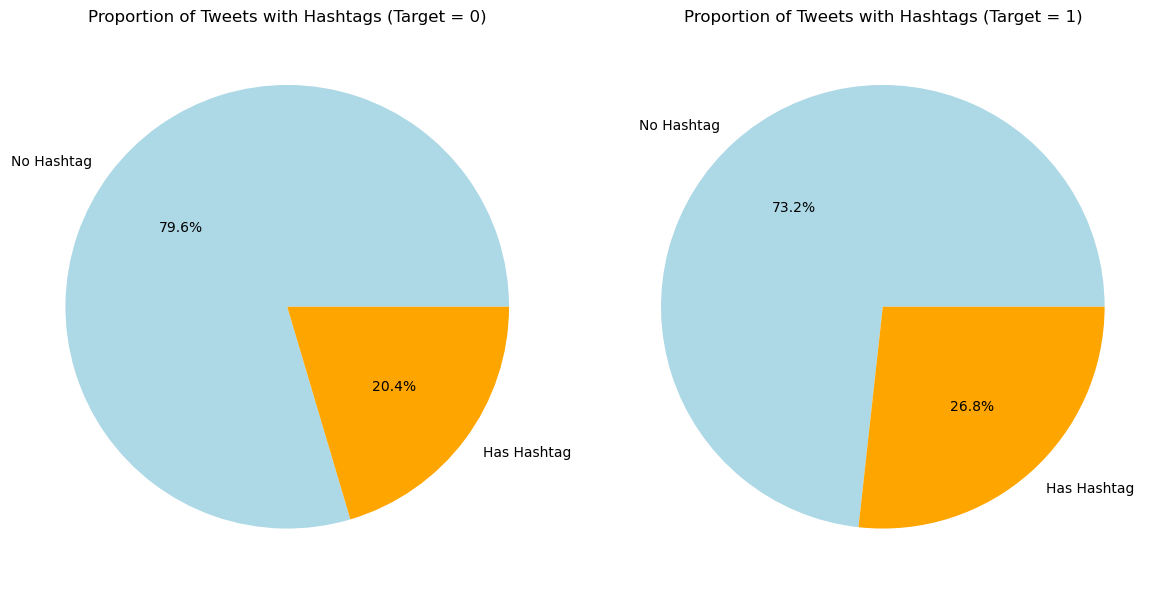

In [182]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for idx, target_value in enumerate([0, 1]):
    hashtag_counts_target = train_df[train_df['target'] == target_value]['has_hashtag'].value_counts()
    axs[idx].pie(hashtag_counts_target, labels=['No Hashtag', 'Has Hashtag'], autopct='%1.1f%%', 
                 colors=['lightblue', 'orange'])
    axs[idx].set_title(f'Proportion of Tweets with Hashtags (Target = {target_value})')

plt.tight_layout()
plt.show()

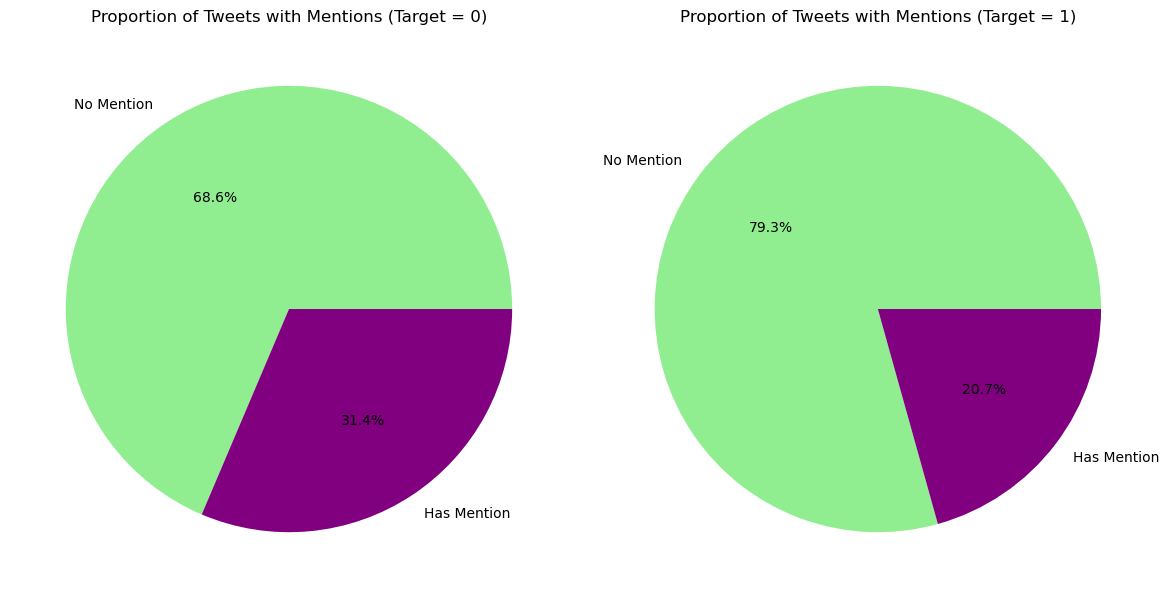

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for idx, target_value in enumerate([0, 1]):
    mention_counts_target = train_df[train_df['target'] == target_value]['has_mention'].value_counts()
    axs[idx].pie(mention_counts_target, labels=['No Mention', 'Has Mention'], autopct='%1.1f%%', 
                 colors=['lightgreen', 'purple'])
    axs[idx].set_title(f'Proportion of Tweets with Mentions (Target = {target_value})')

plt.tight_layout()
plt.show()

Disaster Tweets have more Hashtags where Non Disaster tweets have more mentions.

In [184]:
# Group keywords by target and count occurrences
grouped_keywords = train_df.groupby('target')['keyword'].value_counts()

# Print top 20 keywords for each target
print("Top 20 keywords for non-disaster tweets (target=0):")
print(grouped_keywords[0].head(20))

print("\nTop 20 keywords for disaster tweets (target=1):")
print(grouped_keywords[1].head(20))

Top 20 keywords for non-disaster tweets (target=0):
keyword
body%20bags    40
armageddon     37
harm           37
deluge         36
ruin           36
wrecked        36
explode        35
fear           35
siren          35
twister        35
aftershock     34
panic          34
screaming      34
blaze          33
blazing        33
blizzard       33
crush          33
sinking        33
traumatised    33
bloody         32
Name: keyword, dtype: int64

Top 20 keywords for disaster tweets (target=1):
keyword
derailment               39
outbreak                 39
wreckage                 39
debris                   37
oil%20spill              37
typhoon                  37
evacuated                32
rescuers                 32
suicide%20bomb           32
suicide%20bombing        32
nuclear%20disaster       31
razed                    31
airplane%20accident      30
earthquake               30
suicide%20bomber         30
bridge%20collapse        29
collision                29
wildfire           

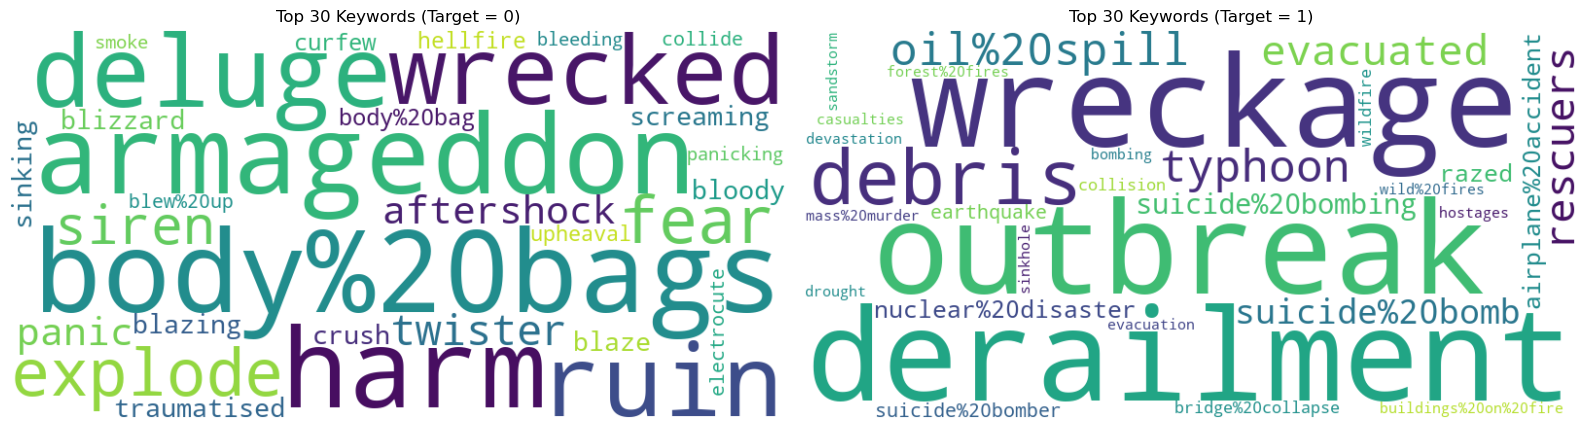

In [185]:
from wordcloud import WordCloud

# Generate word clouds for each target value
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for idx, target_value in enumerate([0, 1]):
    # Filter top 30 keywords for the target value
    top_keywords = grouped_keywords[target_value].head(30)
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_keywords)
    
    # Display the word cloud
    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].axis('off')
    axs[idx].set_title(f'Top 30 Keywords (Target = {target_value})')

plt.tight_layout()
plt.show()

It is worth noting there exists no same word in the top 30 words between disaster tweet vs non disaster tweet.

## Preprocessing

In [186]:

def clean_text(text):

    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



In [187]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [188]:
train_df['cleaned_text'].head(5)

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: cleaned_text, dtype: object

In [189]:
MAX_NUM_WORDS = 10000

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

all_texts = pd.concat([train_df['cleaned_text'], test_df['cleaned_text']])

tokenizer.fit_on_texts(all_texts)
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(train_sequences, maxlen=50)
X_test = pad_sequences(test_sequences, maxlen=50)

In [190]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 21571


In [191]:
targets = train_df['target'].values

In [192]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, targets, test_size=0.2
)

## Building the Model
### Model 1

In [193]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout


In [105]:
model = Sequential([

    Embedding(input_dim=MAX_NUM_WORDS, 
              output_dim=100,
              input_length=50),
    
    SimpleRNN(units=64),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,010,625
Trainable params: 1,010,625
Non-trainable params: 0
_________________________________________________________________


We will be training about 1MM parameters

## Fitting the Model

In [106]:
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/10


191/191 [==============================] - 6s 25ms/step - loss: 0.5904 - accuracy: 0.6800 - val_loss: 0.4983 - val_accuracy: 0.7787
Epoch 2/10
191/191 [==============================] - 4s 22ms/step - loss: 0.2593 - accuracy: 0.9041 - val_loss: 0.5881 - val_accuracy: 0.7479
Epoch 3/10
191/191 [==============================] - 4s 21ms/step - loss: 0.1184 - accuracy: 0.9645 - val_loss: 0.6558 - val_accuracy: 0.7623
Epoch 4/10
191/191 [==============================] - 4s 23ms/step - loss: 0.0859 - accuracy: 0.9731 - val_loss: 0.6544 - val_accuracy: 0.7623
Epoch 5/10
191/191 [==============================] - 5s 24ms/step - loss: 0.0680 - accuracy: 0.9777 - val_loss: 0.6798 - val_accuracy: 0.7617
Epoch 6/10
191/191 [==============================] - 4s 24ms/step - loss: 0.0597 - accuracy: 0.9770 - val_loss: 0.7088 - val_accuracy: 0.7584
Epoch 7/10
191/191 [==============================] - 4s 21ms/step - loss: 0.0564 - accuracy: 0.9790 - val_loss: 0.7089 - val_accuracy: 0.7669
Epoch 8/10

In [ ]:
# create reusable function to plot training history

def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

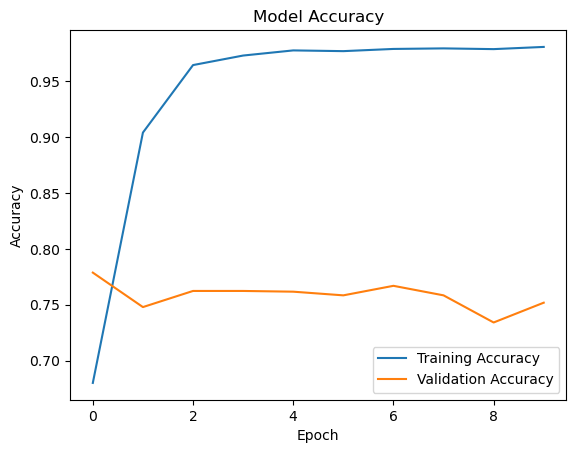

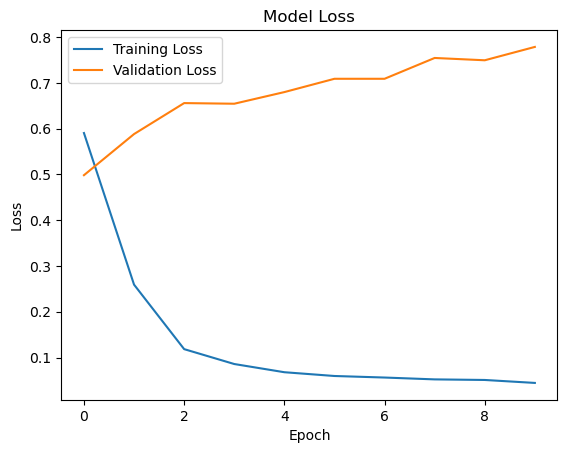

In [110]:
plot_training_history(history)

### Model 1 Anaysis

Our first model suffers from overfitting badly.  Let's apply some regularizations.

### Model 2 with dropouts

In [116]:
model2 = Sequential([

    Embedding(input_dim=MAX_NUM_WORDS, 
              output_dim=100,
              input_length=50),
    
    SimpleRNN(units=64, dropout=0.4, recurrent_dropout=0.4),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 100)           1000000   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,010,625
Trainable params: 1,010,625
Non-trainable params: 0
_________________________________________________________________


In [117]:
BATCH_SIZE = 32
EPOCHS = 10

history2 = model2.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10


191/191 [==============================] - 7s 32ms/step - loss: 0.7123 - accuracy: 0.5328 - val_loss: 0.6528 - val_accuracy: 0.6776
Epoch 2/10
191/191 [==============================] - 6s 30ms/step - loss: 0.6418 - accuracy: 0.6287 - val_loss: 0.6020 - val_accuracy: 0.6717
Epoch 3/10
191/191 [==============================] - 7s 34ms/step - loss: 0.4950 - accuracy: 0.7726 - val_loss: 0.5767 - val_accuracy: 0.7551
Epoch 4/10
191/191 [==============================] - 5s 28ms/step - loss: 0.3520 - accuracy: 0.8593 - val_loss: 0.5946 - val_accuracy: 0.7807
Epoch 5/10
191/191 [==============================] - 6s 33ms/step - loss: 0.2780 - accuracy: 0.8903 - val_loss: 0.7210 - val_accuracy: 0.7708
Epoch 6/10
191/191 [==============================] - 6s 30ms/step - loss: 0.2221 - accuracy: 0.9167 - val_loss: 0.7471 - val_accuracy: 0.7682
Epoch 7/10
191/191 [==============================] - 6s 29ms/step - loss: 0.1864 - accuracy: 0.9309 - val_loss: 0.8384 - val_accuracy: 0.7636
Epoch 8/10

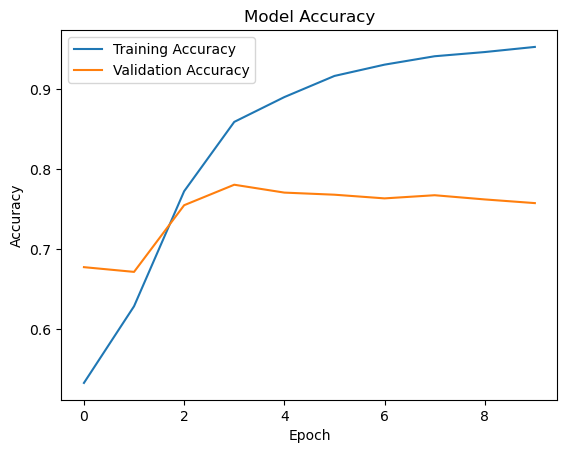

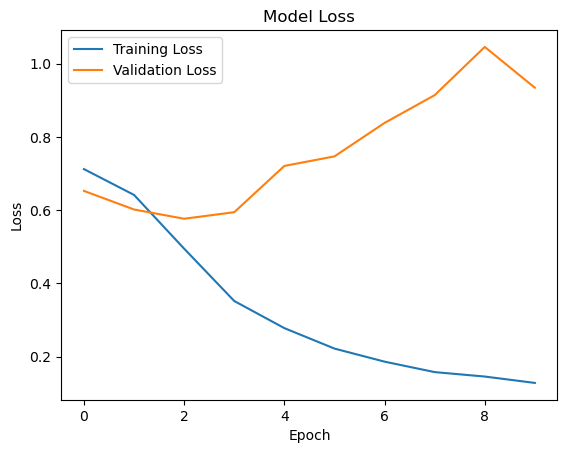

In [118]:
plot_training_history(history2)

### Model 2 Analysis
Even with updated regularization with dropouts, it still suffers from overfitting. Let's increase the dimensionality of our data

### Model 3 With Dropout and larger dimension size

In [194]:
tokenizer = Tokenizer()

all_texts = pd.concat([train_df['cleaned_text'], test_df['cleaned_text']])

tokenizer.fit_on_texts(all_texts)
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(train_sequences, maxlen=50)
X_test = pad_sequences(test_sequences, maxlen=50)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, targets, test_size=0.2
)

In [198]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 21684


In [199]:
model3 = Sequential([

    Embedding(input_dim=vocab_size, 
              output_dim=300,
              input_length=50),
    
    SimpleRNN(units=128, dropout=0.5, recurrent_dropout=0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model3.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 50, 300)           6505200   
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 128)               54912     
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,568,433
Trainable params: 6,568,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

history3 = model3.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/10


191/191 [==============================] - 16s 75ms/step - loss: 0.7417 - accuracy: 0.5136 - val_loss: 0.6735 - val_accuracy: 0.5870
Epoch 2/10
191/191 [==============================] - 14s 72ms/step - loss: 0.7068 - accuracy: 0.5461 - val_loss: 0.6773 - val_accuracy: 0.5870
Epoch 3/10
191/191 [==============================] - 14s 71ms/step - loss: 0.6899 - accuracy: 0.5611 - val_loss: 0.6802 - val_accuracy: 0.5870
Epoch 4/10
191/191 [==============================] - 14s 71ms/step - loss: 0.6382 - accuracy: 0.6381 - val_loss: 0.8042 - val_accuracy: 0.5982
Epoch 5/10
191/191 [==============================] - 14s 72ms/step - loss: 0.4686 - accuracy: 0.7841 - val_loss: 0.7166 - val_accuracy: 0.7525
Epoch 6/10
191/191 [==============================] - 14s 72ms/step - loss: 0.3212 - accuracy: 0.8701 - val_loss: 0.7350 - val_accuracy: 0.7663
Epoch 7/10
191/191 [==============================] - 14s 73ms/step - loss: 0.2346 - accuracy: 0.9140 - val_loss: 0.6863 - val_accuracy: 0.7886
Epo

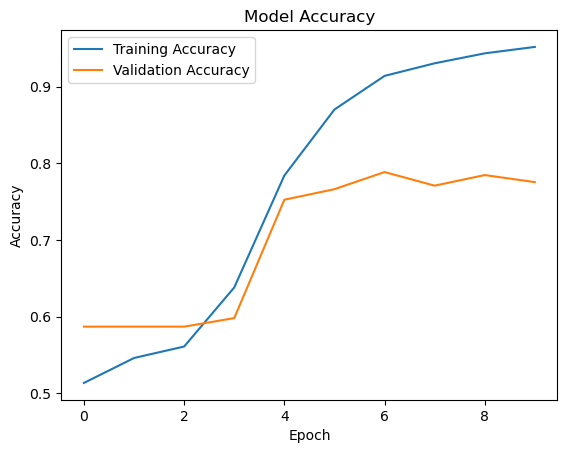

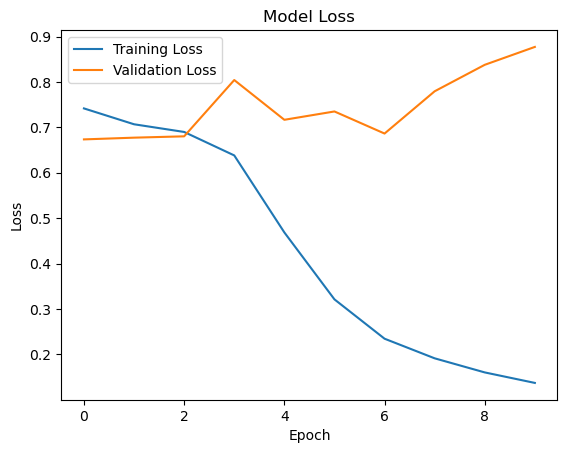

In [131]:
plot_training_history(history3)

### Model 3 Analysis

Although it suffers less from overfitting, we are not getting the validation loss down much more than previous models.

### Reconsidering Preprocessing
We removed stop words from our text.  While removing these commons words makes sense for models like regression, it may not make sense for RNN, since RNN carries context through the sequences of words, the grammatical context that these stop words may produce valuable data.

In [196]:
### Repeating Model 3 with stopwords removed
def clean_text_without_stopword_removal(text):

    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [197]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text_without_stopword_removal)
test_df['cleaned_text'] = test_df['text'].apply(clean_text_without_stopword_removal)

tokenizer = Tokenizer()

all_texts = pd.concat([train_df['cleaned_text'], test_df['cleaned_text']])

tokenizer.fit_on_texts(all_texts)
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train = pad_sequences(train_sequences, maxlen=50)
X_test = pad_sequences(test_sequences, maxlen=50)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, targets, test_size=0.2
)

In [138]:
model3_a = Sequential([

    Embedding(input_dim=vocab_size, 
              output_dim=300,
              input_length=50),
    
    SimpleRNN(units=128, dropout=0.5, recurrent_dropout=0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

model3_a.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model3_a.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 300)           6471300   
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 128)               54912     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,534,533
Trainable params: 6,534,533
Non-trainable params: 0
_________________________________________________________________


In [139]:
BATCH_SIZE = 32
EPOCHS = 18

history3_a = model3_a.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/18


191/191 [==============================] - 17s 83ms/step - loss: 0.7412 - accuracy: 0.5130 - val_loss: 0.6806 - val_accuracy: 0.5765
Epoch 2/18
191/191 [==============================] - 15s 81ms/step - loss: 0.7091 - accuracy: 0.5376 - val_loss: 0.6778 - val_accuracy: 0.5712
Epoch 3/18
191/191 [==============================] - 16s 86ms/step - loss: 0.6915 - accuracy: 0.5589 - val_loss: 0.6763 - val_accuracy: 0.5712
Epoch 4/18
191/191 [==============================] - 19s 102ms/step - loss: 0.6753 - accuracy: 0.5870 - val_loss: 0.6669 - val_accuracy: 0.5857
Epoch 5/18
191/191 [==============================] - 18s 95ms/step - loss: 0.6362 - accuracy: 0.6338 - val_loss: 0.6398 - val_accuracy: 0.6198
Epoch 6/18
191/191 [==============================] - 18s 93ms/step - loss: 0.5164 - accuracy: 0.7586 - val_loss: 0.5997 - val_accuracy: 0.6750
Epoch 7/18
191/191 [==============================] - 18s 96ms/step - loss: 0.3876 - accuracy: 0.8399 - val_loss: 0.6645 - val_accuracy: 0.6802
Ep

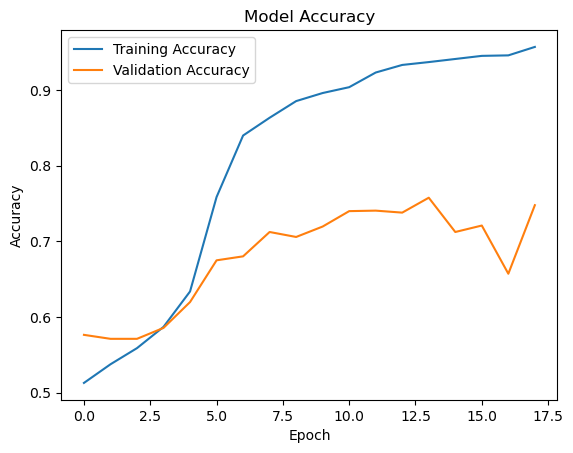

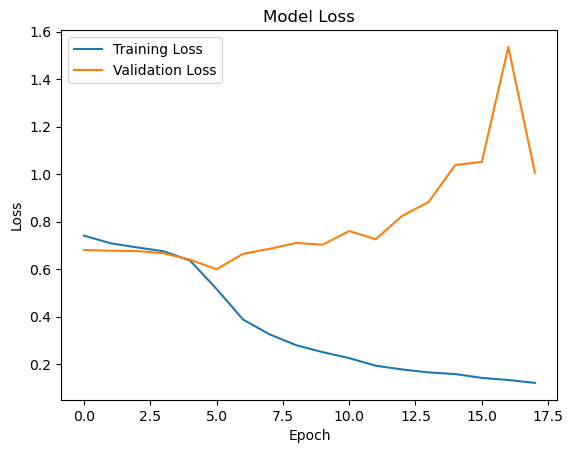

In [140]:
plot_training_history(history3_a)

### Model 3 with no stop words
There's minor improvements but not enough

### Model 4 LSTM

In [142]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

LEARNING_RATE = 0.0001

model4 = Sequential()

model4.add(Embedding(
    input_dim=vocab_size,
    output_dim=300,
    input_length=50
))

model4.add(SpatialDropout1D(0.3))

# First Bidirectional LSTM layer
model4.add(Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))

# Second Bidirectional LSTM layer
model4.add(Bidirectional(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)))

# Dense hidden layers
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.3))

# Output layer
model4.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate
optimizer = Adam(learning_rate=LEARNING_RATE)
model4.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model4.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 300)           6471300   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 256)          439296    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                     

Model 4 with LSTM has 7MM parameters

In [144]:
BATCH_SIZE = 64
EPOCHS = 15

history4 = model4.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/15


96/96 [==============================] - 69s 716ms/step - loss: 0.6850 - accuracy: 0.5680 - val_loss: 0.6817 - val_accuracy: 0.5712
Epoch 2/15
96/96 [==============================] - 64s 662ms/step - loss: 0.6791 - accuracy: 0.5706 - val_loss: 0.6741 - val_accuracy: 0.5712
Epoch 3/15
96/96 [==============================] - 59s 617ms/step - loss: 0.6405 - accuracy: 0.6399 - val_loss: 0.5332 - val_accuracy: 0.7689
Epoch 4/15
96/96 [==============================] - 61s 637ms/step - loss: 0.4677 - accuracy: 0.8090 - val_loss: 0.4579 - val_accuracy: 0.8004
Epoch 5/15
96/96 [==============================] - 62s 650ms/step - loss: 0.3597 - accuracy: 0.8685 - val_loss: 0.4709 - val_accuracy: 0.7984
Epoch 6/15
96/96 [==============================] - 61s 638ms/step - loss: 0.3035 - accuracy: 0.9007 - val_loss: 0.4890 - val_accuracy: 0.8024
Epoch 7/15
96/96 [==============================] - 61s 630ms/step - loss: 0.2436 - accuracy: 0.9202 - val_loss: 0.4888 - val_accuracy: 0.8129
Epoch 8/15

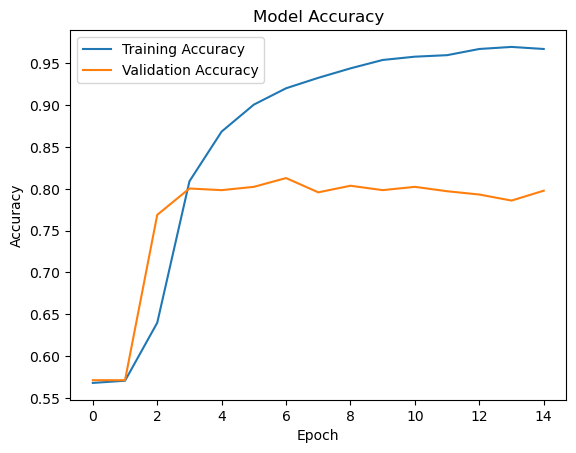

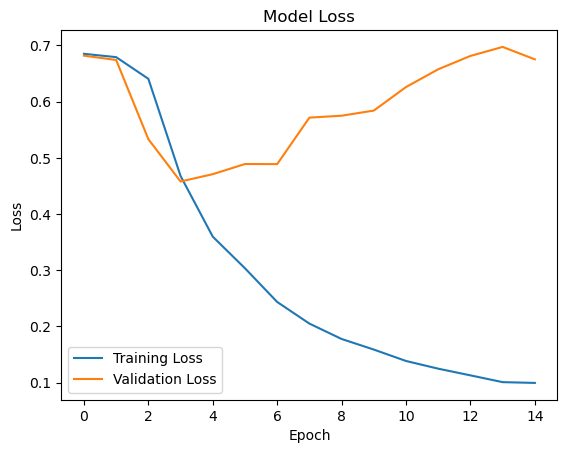

In [145]:
plot_training_history(history4)

#### Model 4 LSTM Analysis

With added complexity with our model, we did better of validation loss.  It still overfits, so we should perform early stopping.

### Model 5 with GloVe Embedding

From https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

By using pre-trained embedding technique, we can extract better information from the text.

In [200]:
# Decreasing the dimension of the embedding layer from 300 to 200
DIM_SIZE = 100

def load_glove_embeddings(word_index):
    print("Loading GloVe embeddings...")
    embeddings_index = {}
    
    glove_path = 'glove.twitter.27B.100d.txt'  # Path to GloVe embeddings
    
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f"Found {len(embeddings_index)} word vectors in GloVe.")
    
    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, DIM_SIZE))
    
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [201]:
embedding_matrix = load_glove_embeddings(tokenizer.word_index)

Loading GloVe embeddings...


Found 1193514 word vectors in GloVe.


In [226]:

model5 = Sequential()

model5.add(Embedding(
    input_dim=vocab_size,
    output_dim=100,
    weights=[embedding_matrix],
    input_length=50,
))

model5.add(SpatialDropout1D(0.4))

model5.add(Bidirectional(LSTM(units=128, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)))

model5.add(Bidirectional(LSTM(units=64, dropout=0.4, recurrent_dropout=0.4, return_sequences=False)))

model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.4))


model5.add(Dense(1, activation='sigmoid'))

LEARNING_RATE = 0.001
optimizer = Adam(learning_rate=LEARNING_RATE)

model5.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model5.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 50, 100)           2168400   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 50, 100)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional_20 (Bidirecti  (None, 50, 256)          234496    
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dense_54 (Dense)            (None, 64)                8256      
                                                     

In [227]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=5e-7,
    verbose=1
)

In [228]:

print("\nTraining the model...")
history5 = model5.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_learning_rate],
    verbose=1
)


Training the model...
Epoch 1/20


191/191 [==============================] - 104s 485ms/step - loss: 0.5695 - accuracy: 0.7171 - val_loss: 0.4552 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - 94s 490ms/step - loss: 0.4845 - accuracy: 0.7852 - val_loss: 0.4543 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - 95s 497ms/step - loss: 0.4399 - accuracy: 0.8103 - val_loss: 0.4288 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - 103s 539ms/step - loss: 0.3930 - accuracy: 0.8350 - val_loss: 0.4751 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 5/20
191/191 [==============================] - 99s 517ms/step - loss: 0.3589 - accuracy: 0.8489 - val_loss: 0.4823 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 6/20
191/191 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8726
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
191/191 [==============================] - 92s 

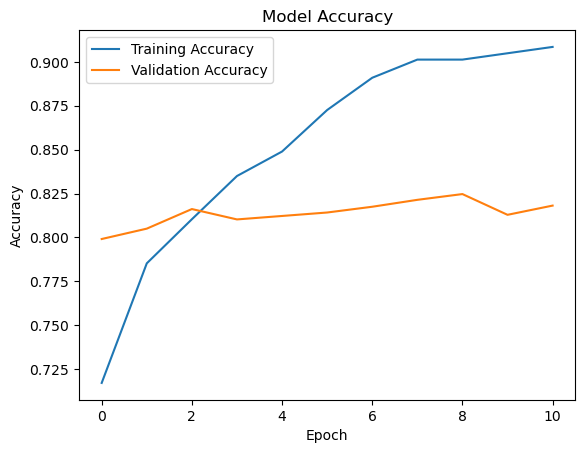

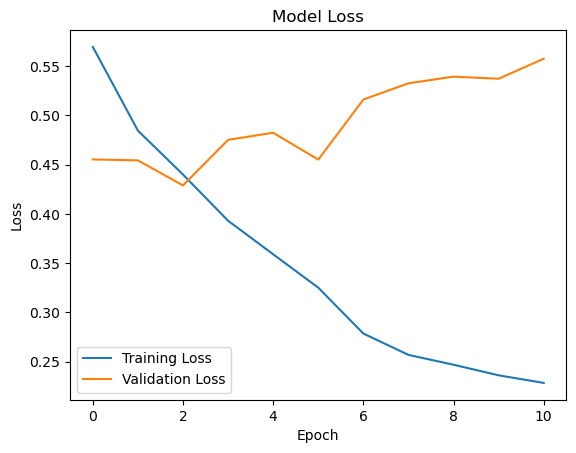

In [229]:
plot_training_history(history5)

### Model 5 analysis with LSTM, GloVe embeddings, and early stopping
While it resulted in the best model as of yet, it still had overfitting, even with regularization.  This could be due to using too many dimensions as well as too many layers.  In other words, the model was too complex for the problem

In [230]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

y_pred_proba = model5.predict(X_val)
y_pred = (y_pred_proba > 0.5).astype(int)



48/48 [==============================] - 6s 114ms/step


### Validation Data result

Validation Accuracy: 0.8162

Confusion Matrix:
[[730 137]
 [143 513]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       867
           1       0.79      0.78      0.79       656

    accuracy                           0.82      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



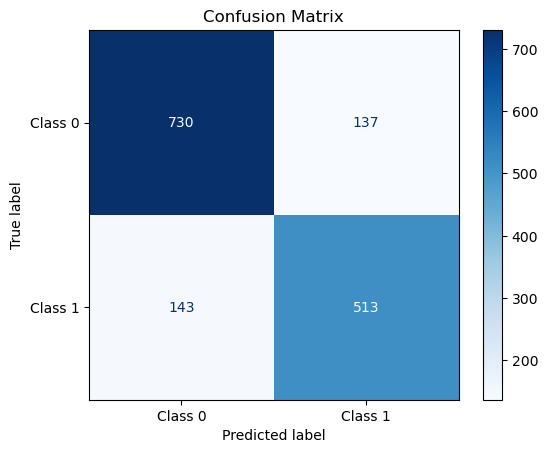

In [231]:
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')  # Use a blue colormap for better visualization
plt.title('Confusion Matrix')
plt.show()

## Running Predictions

In [232]:
y_pred_proba = model5.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

  1/102 [..............................] - ETA: 17s

102/102 [==============================] - 12s 114ms/step


In [235]:

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': y_pred.reshape(-1,)
})

submission_df.to_csv('submission.csv', index=False)

## Conclusion

We went through various technique in order to improve the model.
First, we used a simple RNN model.
Second, then we aded some dropouts.
Third, we increased the dimensionality of the embedding.  (100 to 300.  This probably was too much that lead to severe overfitting)
Fourth, we used LSTM to get better context of the sentences.
Fifth, we used pretrained GloVE embedding technique to get better embedding from the words.

In the end, we ended up with about 80-82% in terms of prediction accuracy.

## Further studies
We could have looked into analyzing the keyword and other factors like mentions an hashtag to create a regression model, then combine it with our LSTM model to create an ensemble model.  This would capture other dataset like mentions, keyword, hashtags, and location to improve the overall accuracy.